# Elastic+Plastic+Adhesion Simulation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from SurfaceTopography import Topography, read_published_container
from ContactMechanics import FreeFFTElasticHalfSpace
from Adhesion.Interactions import Exponential
from Adhesion.System import make_system
from Adhesion.System import BoundedSmoothContactSystem
from ContactMechanics.Tools.Logger import screen, Logger

## Prepare Geometry

In [ ]:
c, = read_published_container('https://contact.engineering/go/b9zfz')

In [ ]:
[t.info["name"] for t in c ]

['randsurf.mat']

In [ ]:
topography = c[0]

In [ ]:
nx, ny = 512, 512 # number of gridpoints in x,y of AFM scans

In [ ]:
sx,sy= 20, 20 # scan size in um

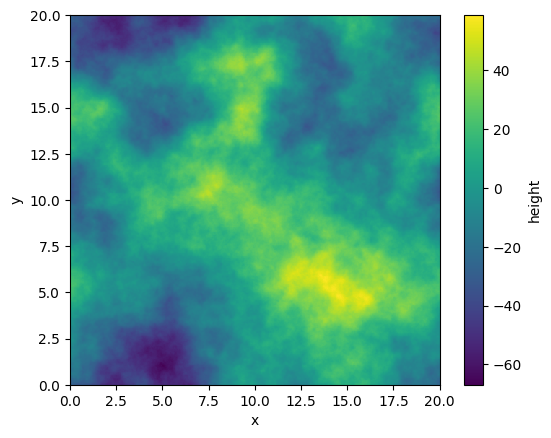

In [ ]:
fig, ax = plt.subplots()
X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
pcm = ax.pcolormesh(X,Y, topography.heights())
cb = plt.colorbar(pcm,ax= ax, label= "height")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)

Text(0, 0.5, 'heights ($z_0$)')

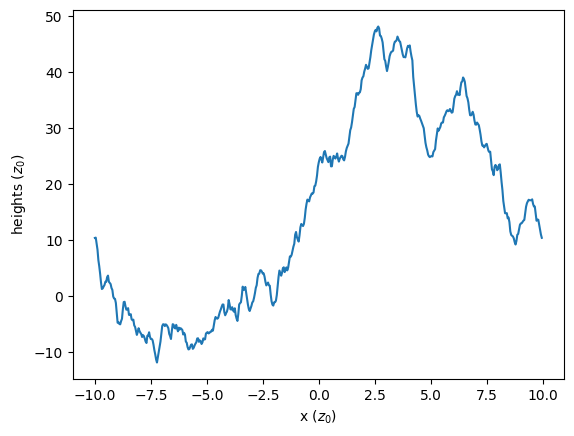

In [ ]:
x = np.arange(0, nx).reshape(-1,1 ) * sx/nx - sx / 2
y = np.arange(0, ny).reshape(1,-1 ) * sy/ny - sy / 2
fig, ax = plt.subplots()
ax.plot(x, topography.heights()[:, ny//3])
ax.set_aspect(0.25)
ax.set_xlabel("x ($z_0$)")
ax.set_ylabel("heights ($z_0$)")

## Material Properties

In [ ]:
Es =  50
alpha = 0.8 
w = (alpha**2)*np.pi / 2
rho = sx/nx

## setup system


In [ ]:
system = make_system(
    interaction=Exponential(w, rho),
    substrate=FreeFFTElasticHalfSpace(nb_grid_pts=topography.nb_grid_pts, young=Es,physical_sizes=topography.physical_sizes,check_boundaries=False),
    surface=topography,
    system_class=BoundedSmoothContactSystem
        )

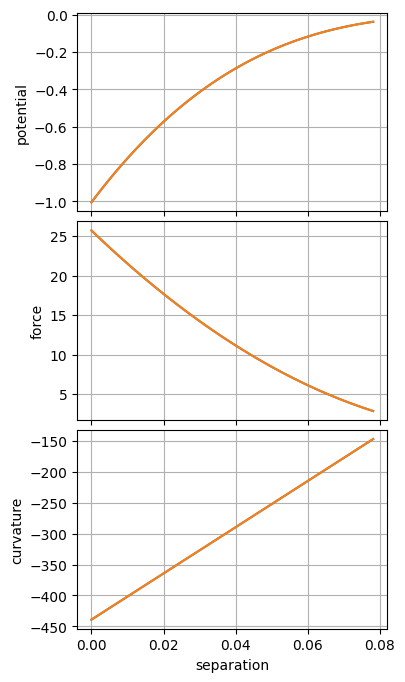

In [ ]:
fig, ax = plt.subplots(3, sharex=True, figsize = (4,8))

z =np.linspace(0.85*rho,2*rho)
for poti in [Exponential(w, rho), system.interaction]:
    p,f,c = poti.evaluate(z, True, True, True)
    ax[0].plot(z,p)
    ax[1].plot(z,f)
    ax[2].plot(z,c)
    ax[0].set_ylabel("potential")
    ax[1].set_ylabel("force")
    ax[2].set_ylabel("curvature")
for a in ax:
    a.grid()
    
ax[2].set_xlabel("separation")
fig.subplots_adjust(hspace=0.05)

#### loading history

In [ ]:
penetrations = np.linspace(-50,-10,5)
#penetrations = np.concatenate((penetrations, penetrations[-2::-1]))

### Simulate

Choice of the gradient tolerance: The gradient is the error in the balance 
of the elastic-force and the adhesive force on each pixel. 

This error should be small compared to this force. 

In plastic and adhesive simulations the pressures are bopund by the hardness or 
the maximum interaction stress. This value multiplied by the pixel size gives us 
the order of magnitude of the pixel forces. These forces increase with pixel size, 
and so do the achievable gradient tolerance. 
 

In [ ]:
gtol = 1e-9

In [ ]:
# prepare empty arrays to contain results
offsets = []
normal_forces = []
repulsive_areas = []
forces = np.zeros((len(penetrations), *topography.nb_grid_pts)) # forces[timestep,...]: array of forces for each gridpoint
elastic_displacements = np.zeros((len(penetrations), *topography.nb_grid_pts))
disp0=None
i=0
active_set = [] # List of contact points at each pressure
CP = []
for penetration in penetrations:
    print(f"penetration = {penetration}")
    sol = system.minimize_proxy(                                       
        initial_displacements=disp0,                                                                                       
        options=dict(gtol=gtol, # max absolute value of the gradient of the objective for convergence 
                     ftol=0, # stop only if the gradient criterion is fullfilled
                     maxcor=3 # number of gradients stored for hessian approximation
                    ),                               
        logger=Logger("laststep.log"),                                 
        offset=penetration,                                           
        callback=None,                                                 
                )
    assert sol.success, sol.message
    disp0 = u = system.disp # TODO: the disp0 should only include the elastic displacements. u contains ela
    normal_forces.append(system.compute_normal_force())
    repulsive_areas.append(system.compute_repulsive_contact_area())
    forces[i,...] = - system.substrate.evaluate_force(u)[system.substrate.topography_subdomain_slices]
    active_set = forces[i] >gtol
    CP.append(active_set)
    print(len(CP[0]))
    i+=1

penetration = -50.0


/usr/local/lib/python3.10/dist-packages/ContactMechanics/Systems.py:327: OptimizeWarning: Unknown solver options: ftol, maxcor
  result = scipy.optimize.minimize(


AssertionError: Desired error not necessarily achieved due to precision loss.

Bug small steps in the not yet in contact region leads to problems, why ? 

## plot pressure distributions and deformed profiles

In [ ]:
for i in range(len(penetrations)):
    
    X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
    fig, (ax, ax2) = plt.subplots(1,2, figsize = (5,2))
    
    contact_areas = forces[i]>0.000001
    ax.pcolormesh(X,Y,contact_areas)
    ax.set_xlabel("x (mm)")
    ax.set_ylabel("y (mm)")
    ax.set_aspect(1)
    
    plt.colorbar(ax2.pcolormesh(X,Y,forces[i]/system.area_per_pt), label="pressures MPa")
    ax2.set_xlabel("x (mm)")
    ax2.set_ylabel("y (mm)")
    ax2.set_aspect(1)

    fig.tight_layout()

In [ ]:
for i in [0,1,2,3,4]:
    X, Y = np.meshgrid(np.arange(nx+1) * sx/nx, np.arange(ny+1) * sy/ny, indexing='ij') 
    fig, ay = plt.subplots()
    contact_areas = forces[i]>0.000001
    ay.pcolormesh(X,Y,contact_areas)
    ay.set_xlabel("x")
    ay.set_ylabel("y")
    ay.set_aspect(1)